In [8]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from PIL import ImageFile, Image
import datetime
import os

In [9]:
def display_image_in_actual_size(img_path):
    dpi = 100
    img_data = plt.imread(img_path)
    height, width, depth = img_data.shape
    # What size does the figure need to be in inches to fit
    # the image?
    figsize = width / float(dpi), height / float(dpi)
    # Create a figure of the right size with one axis that
    # takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    # Display the image.
    ax.imshow(img_data, cmap='gray')
    plt.show()

In [10]:
path = 'DATASET/TRAIN/downdog/'
images = ['00000128.jpg', '00000130.jpg']

# for img in images:
#     display_image_in_actual_size(path + img)

# Loading and preprocessing the data

In [11]:
# In this cell we've defined:
#  - the directory path of the dataset,
#  - the batch size for loading images,
#  - the image size (all images will be resized to this size) 
#  - the proportion of the dataset to be used for validation

TRAIN_PATH = 'DATASET/TRAIN/'
TEST_PATH = 'DATASET/TRAIN/'

BATCH_SIZE = 32
NUM_EPOCHS = 20

pixels =128
IMAGE_SIZE = (pixels, pixels)

VALIDATTION_PERCENTAGE = 0.2

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=.20)

In [13]:
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="bilinear", color_mode="grayscale")

train_generator = datagen.flow_from_directory(TRAIN_PATH, subset="training", shuffle=True,  **dataflow_kwargs)
validation_generator = datagen.flow_from_directory(TRAIN_PATH, subset="validation", shuffle=False,  **dataflow_kwargs)


Found 862 images belonging to 5 classes.
Found 213 images belonging to 5 classes.


In [14]:
image, label = next(train_generator)
image.shape, len(train_generator)

((32, 256, 256, 1), 27)

In [15]:
testgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_generator = datagen.flow_from_directory(TEST_PATH, shuffle=False,  **dataflow_kwargs)


Found 1075 images belonging to 5 classes.


In [16]:
# The output is represented as NumPy arrays. For a batch of
# images, the sample size is 32, with 224 pixels in height and
# width and three channels representing RGB color space.

# For the label batch, there are likewise 32 samples. Each row
# is onehot encoded to represent which of the five classes it belongs to.

for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 1)
(32, 5)


In [17]:
# retrieve the lookup dictionary of labels
labels_idx = (train_generator.class_indices)
idx_labels = dict((v,k) for k,v in labels_idx.items())
print(idx_labels)

{0: 'downdog', 1: 'goddess', 2: 'plank', 3: 'tree', 4: 'warrior2'}


In [18]:
# Saving the idx_labels dictionary
with open('prediction_lookup.pickle', 'wb') as handle:
    pickle.dump(idx_labels, handle,
    protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('prediction_lookup.pickle', 'rb') as handle:
    lookup = pickle.load(handle)
lookup

{0: 'downdog', 1: 'goddess', 2: 'plank', 3: 'tree', 4: 'warrior2'}

# Creating the model 

In [20]:
# define input shape
input_shape = (pixels, pixels, 1)

# initialize the model
model = Sequential()

# add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten the output of the convolutional layers
model.add(Flatten())

# add fully connected layers with dropout
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



2023-04-18 23:24:44.381215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 23:24:44.381625: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
# A brief summary of the model and parameters
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 254, 254, 32)          320         
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 127, 127, 32)          0           
                                                                           
 conv2d_1 (Conv2D)               (None, 125, 125, 64)          18496       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 62, 62, 64)            0           
                                                                           
 conv2d_2 (Conv2D)               (None, 60, 60, 128)           73856       
                                                                           
 max_pooling2d_2 (MaxPooling2D)  (None, 30, 30, 128)           0    

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Creating Callbacks

### Early Stopping Callback

In [23]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

### Tensorboard Callback

In [24]:
log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

## Trainning the model 

In [25]:
# Train the network
ImageFile.LOAD_TRUNCATED_IMAGES = True

model.fit(
    train_generator, 
    epochs = NUM_EPOCHS, 
    callbacks = [tensorboard_callback, early_stopping], 
    validation_data = validation_generator,
    verbose = 2
)

Epoch 1/20


2023-04-18 23:24:45.001294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/user01/miniconda3/envs/lab/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
2023-04-18 23:25:12.699143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 - 30s - loss: 1.8240 - accuracy: 0.1972 - val_loss: 1.6071 - val_accuracy: 0.2347 - 30s/epoch - 1s/step
Epoch 2/20
27/27 - 30s - loss: 1.6087 - accuracy: 0.2135 - val_loss: 1.6041 - val_accuracy: 0.2864 - 30s/epoch - 1s/step
Epoch 3/20
27/27 - 29s - loss: 1.6054 - accuracy: 0.2378 - val_loss: 1.6013 - val_accuracy: 0.2441 - 29s/epoch - 1s/step
Epoch 4/20
27/27 - 29s - loss: 1.6149 - accuracy: 0.2413 - val_loss: 1.6018 - val_accuracy: 0.2441 - 29s/epoch - 1s/step
Epoch 5/20
27/27 - 29s - loss: 1.6015 - accuracy: 0.2483 - val_loss: 1.5939 - val_accuracy: 0.2441 - 29s/epoch - 1s/step
Epoch 6/20
27/27 - 29s - loss: 1.5923 - accuracy: 0.2541 - val_loss: 1.5862 - val_accuracy: 0.2441 - 29s/epoch - 1s/step
Epoch 7/20
27/27 - 28s - loss: 1.5745 - accuracy: 0.2773 - val_loss: 1.5621 - val_accuracy: 0.3474 - 28s/epoch - 1s/step
Epoch 8/20
27/27 - 28s - loss: 1.5359 - accuracy: 0.3492 - val_loss: 1.5154 - val_accuracy: 0.3427 - 28s/epoch - 1s/step
Epoch 9/20
27/27 - 28s - loss: 1.5212 - acc

## Testing our model

In [26]:
test_loss, test_accuracy = model.evaluate(test_generator)

2023-04-18 23:34:19.179862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


34/34 [==============================] - 11s 327ms/step - loss: 0.9306 - accuracy: 0.7144


NameError: name 'images_plot' is not defined

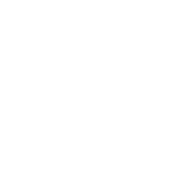

In [27]:
# The image to be displayed and tested
i = 502


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

## Visualizing in Tensorboard

In [28]:
os.environ['TENSORBOARD_BINARY'] = '/home/user01/miniconda3/envs/lab/bin/tensorboard'

%load_ext tensorboard
%tensorboard --logdir 'logs/fit/'


Reusing TensorBoard on port 6006 (pid 12902), started 23:57:00 ago. (Use '!kill 12902' to kill it.)